In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

In [9]:
#librerie per le immagini con risoluzione migliore
#Le ho usate al posto di basemap che non sono riuscito ad installare
#per installarle tutte (con le varie dipendenze): conda install cartopy 
# *(sperando che funzioni :-) )
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import cartopy
import pyproj     #questa converte le coordinate


In [4]:
cols = ['index', 'trigger', 'time', 'magnitude', 'x', 'y', 'z']

df = pd.read_csv("SouthCalifornia-1982-2011_Physics-of-Data.dat", delimiter=" ")
df.columns = cols
#display(data)

#definition of the two reference frames 
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84') #euclidean
lla  = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84') #latlon

#coordinates conversion
gcoor = df.apply(lambda row: pyproj.transform(ecef, lla, row.x, row.y, row.z, radians=False),
                   axis=1, result_type='expand')
gcoor.columns = ['longitude', 'latitude', 'depth']
df = pd.concat([df, gcoor], axis=1)


#Old transformation method
import math 

R = 6371005

def xyz_to_latlon (x,y,z):
    """Convert cartesian to angular lat/lon coordiantes"""
    r = math.sqrt(x**2 + y**2 + z**2)
    rad = np.abs(r - R)
    theta = math.asin(z/r) # https://stackoverflow.com/a/1185413/4933053
    phi = math.atan2(y,x)
    lat = math.degrees(theta)
    lon = math.degrees(phi)
    return lat, lon, rad

lat = np.empty(df.shape[0], object)
lon = np.empty(df.shape[0], object)
rad = np.empty(df.shape[0], object)

for i in range(df.shape[0]):
    lat[i],lon[i],rad[i] = xyz_to_latlon(np.array(df.iloc[i,-6]), np.array(df.iloc[i,-5]), np.array(df.iloc[i,-4]))

#create new columns with old transformed coordinates 
df['latitude1'] = lat
df['longitude1'] = lon
df['depth1'] = rad 

In [5]:
display(df.head(10))

,index,trigger,time,magnitude,x,y,z,longitude,latitude,depth,latitude1,longitude1,depth1
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602,-119.067002,33.803070,-13866.339244,33.625,-119.067,13314.8
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373,-116.279332,33.133255,-9094.154542,32.9571,-116.279,8313.42
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232,-116.279718,33.132481,-9220.807091,32.9563,-116.28,8439.81
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479,-117.953814,34.081790,-9788.561414,33.9031,-117.954,9333.14
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546,-114.825995,33.229464,-10453.018623,33.053,-114.826,9705.06
5,5,0,100612.80864,2.04,-2545592,-4588519,3597315,-119.020383,34.612570,-9262.553341,34.4326,-119.02,8991.13
6,6,0,106358.95296,2.27,-2361034,-4748837,3502194,-116.435716,33.617193,-16205.574302,33.4395,-116.436,15590.2
7,7,0,127529.37216,2.64,-2484433,-4558759,3679010,-118.589506,35.504146,-7804.368399,35.3222,-118.59,7844.97
8,8,0,130364.57088,2.62,-2429713,-4582352,3681247,-117.933999,35.547482,-10679.144894,35.3653,-117.934,10735
9,9,0,134132.56128,2.48,-2526232,-4571575,3618942,-118.924844,34.897689,-16817.362012,34.7168,-118.925,16645.3


In [6]:
import datetime
import time

#datetime.datetime.today()
#datetime.datetime.fromtimestamp(time.time())

#offset = datetime.datetime.fromisoformat('1982-01-01').strftime('%s') #.ctime()

offset = (datetime.datetime.fromisoformat('1982-01-01') - datetime.datetime.fromisoformat('1970-01-01')).total_seconds() 

#x = (datetime.datetime.fromisoformat('1987-01-01') - datetime.datetime.fromisoformat('1982-01-01')).total_seconds() + offset
#y = float( datetime.datetime.fromtimestamp(x).year )
#datetime.datetime.now()

df['total_second'] = df['time'] + offset 

#df['year'] = datetime.datetime.fromtimestamp( df['total_second'] ).year 

y = np.empty(df['time'].values.shape[0], int)

for i in range(df['time'].values.shape[0]):
    y[i] = datetime.datetime.fromtimestamp( df['total_second'].values[i] ).year 

df['year'] = y
m=2
df = df[df['magnitude']>=m]

In [7]:
display(df.head(10))

,index,trigger,time,magnitude,x,y,z,longitude,latitude,depth,latitude1,longitude1,depth1,total_second,year
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602,-119.067002,33.803070,-13866.339244,33.625,-119.067,13314.8,3.786912e+08,1982
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373,-116.279332,33.133255,-9094.154542,32.9571,-116.279,8313.42,3.787277e+08,1982
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232,-116.279718,33.132481,-9220.807091,32.9563,-116.28,8439.81,3.787287e+08,1982
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479,-117.953814,34.081790,-9788.561414,33.9031,-117.954,9333.14,3.787392e+08,1982
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546,-114.825995,33.229464,-10453.018623,33.053,-114.826,9705.06,3.787515e+08,1982
5,5,0,100612.80864,2.04,-2545592,-4588519,3597315,-119.020383,34.612570,-9262.553341,34.4326,-119.02,8991.13,3.787918e+08,1982
6,6,0,106358.95296,2.27,-2361034,-4748837,3502194,-116.435716,33.617193,-16205.574302,33.4395,-116.436,15590.2,3.787976e+08,1982
7,7,0,127529.37216,2.64,-2484433,-4558759,3679010,-118.589506,35.504146,-7804.368399,35.3222,-118.59,7844.97,3.788187e+08,1982
8,8,0,130364.57088,2.62,-2429713,-4582352,3681247,-117.933999,35.547482,-10679.144894,35.3653,-117.934,10735,3.788216e+08,1982
9,9,0,134132.56128,2.48,-2526232,-4571575,3618942,-118.924844,34.897689,-16817.362012,34.7168,-118.925,16645.3,3.788253e+08,1982


AttributeError: module 'cartopy.io.img_tiles' has no attribute 'Stamen'

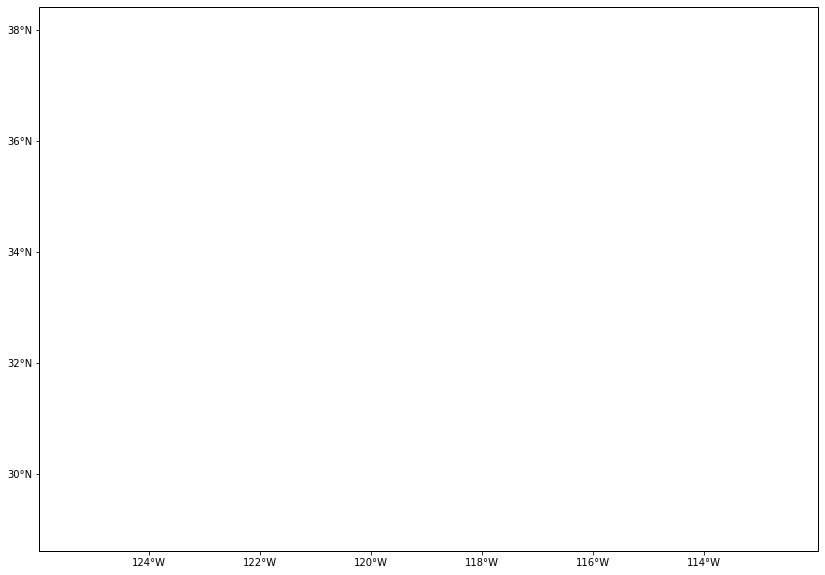

In [8]:
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

#formatting axes ticks
ax.set_xticks([-114, -116, -118, -120, -122, -124], crs=ccrs.PlateCarree())
ax.set_yticks([30, 32, 34, 36, 38], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)


extent = [-125.97, -111.95, 28.62, 38.41]
ax.set_extent(extent)

#downloading BACKGROUND from STAMEN MAPS 
stamen_terrain = cimgt.Stamen('terrain-background')
ax.add_image(stamen_terrain, 7)   
  # Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.

#Some cities
  #San Francisco position
plt.plot(-122.4194200,  37.7749300, 'bo', ms=6)
SFlabel = plt.text(-124, 38, 'San Francisco', fontsize=12, color='blue', style='italic')
  #Las Vegas position
plt.plot(-115.172813, 36.114647, 'bo', ms=6)
SFlabel = plt.text(-114.8, 36.2, 'Las Vegas', fontsize=12, color='blue', style='italic')
  #Phoenix position
plt.plot(-112.074036, 33.448376, 'bo', ms=6)
SFlabel = plt.text(-113.2, 33.6, 'Phoenix', fontsize=12, color='blue', style='italic')
  #Los Angeles position
plt.plot(-118.243683, 34.052235, 'bo', ms=6)
SFlabel = plt.text(-120.1, 33.8, 'Los Angeles', fontsize=12, color='blue', style='italic')


START_YEAR = 1982
LAST_YEAR = 2011

points = df[df['year']==START_YEAR]

x, y = list(points['longitude']), list(points['latitude'])

mag = list( (np.exp(1.15*points['magnitude'])) )

color = list(points['depth']/1000.)

scat = plt.scatter(x, y, s = mag,  marker='o', alpha=0.7, c = color, cmap = 'hot')  #s = points['magnitude']*points['depth']*0.3, marker='o', alpha=0.3, zorder=10, cmap = cmap)

year_text = plt.text(-125.5, 29., str(START_YEAR), fontsize=30, color='black')

plt.title("Earthquake visualisation (1982 - 2011)", fontsize=18)

for magn in [2, 3, 4, 5, 6]:
    plt.scatter([], [], c='black', alpha=0.7, s=np.exp(1.15*magn), label=str(magn))
    
leg = plt.legend(scatterpoints=1, frameon=False, labelspacing=2, title='Magnitude', loc="upper left")
plt.setp(leg.get_title(), color='black', fontsize=12)
plt.setp(leg.get_texts(), color='black')

cbar = plt.colorbar(scat, shrink = 0.9)
cbar.set_label('Depth [km]', fontsize=14)
#plt.clim(100000,120000)

plt.axis(aspect='equal')
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.close()

def update(frame_number):
    
    current_year = START_YEAR + (frame_number % (LAST_YEAR - START_YEAR ))
    
    year_text.set_text(str(current_year))
    points = df[df['year']==current_year]
    
    x, y = list(points['longitude']), list(points['latitude'])
    mag = list( (np.exp(1.15*points['magnitude'])) )
    colors = list(points['depth']/1000.)

    scat.set_offsets(np.c_[x,y]) #np.dstack((x, y)))
    scat.set_cmap('hot')
    #scat.set_array()
    scat.set_sizes(mag)
    
    
ani = animation.FuncAnimation(fig, update, interval=100, frames=LAST_YEAR - START_YEAR)

ani.save('animation.gif', writer='imagemagick', fps=1)    


import io
import base64

filename = 'animation.gif'

video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))